In [1]:
import numpy as np
import scipy.sparse as sp
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import ipywidgets
import random

In [2]:
import discretize
from discretize.utils import mesh_builder_xyz, refine_tree_xyz
from SimPEG.potential_fields import magnetics as mag
from SimPEG.utils import mkvc, surface2ind_topo
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
    utils
)
from pymatsolver import Pardiso as Solver


In [3]:
inflight=2     # inflight sampling is 1; landed sampling is 0; 2 is a grid
use_topo=False     # topography or not? 
gauss_noise=0   # large wavelength noise on is 1.

In [4]:
target_magnetization_inclination = 45
target_magnetization_declination = 90 

target_magnetization_direction = utils.mat_utils.dip_azimuth2cartesian(
    target_magnetization_inclination, target_magnetization_declination
)

target_magnetization_amplitude = 10 # magnetization in A/m
target_magnetization = target_magnetization_amplitude * target_magnetization_direction

In [5]:
[xx, yy] = np.meshgrid(np.linspace(-600, 600, 50), np.linspace(-600, 600, 50))
b = 100
A = 50

if use_topo is True:
    zz = -A * np.exp(-0.5 * ((xx / b) ** 2.0 + (yy / b) ** 2.0))
else: 
    zz = np.zeros_like(xx)
    
topo = np.c_[mkvc(xx), mkvc(yy), mkvc(zz)]

In [7]:
if inflight == 1:  #inflight measuremenets 
    line_length = 600
    n_data_along_line = 30
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = np.r_[-50,0, 50] 
    survey_z = np.r_[10]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])
    
    xx = np.linspace(0, 7, n_data_along_line)
    xx =np.concatenate([xx,xx,np.flip(xx)])
    
    survey_xyz[:,1] = survey_xyz[:,1]*xx
    survey_z = np.linspace(1, 30, int(n_data_along_line/2))
    zz = np.concatenate([survey_z, np.flip(survey_z), survey_z, np.flip(survey_z), survey_z, np.flip(survey_z)])
    survey_xyz[:,2] = zz

elif inflight == 2: # grid
    line_length = 600
    n_data_along_line = 15
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = survey_x
    survey_z = np.r_[10]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])

else:
    line_length = 600
    n_data_along_line = 6
    survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
    survey_y = np.r_[0] 
    survey_z = np.r_[1]
    survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])

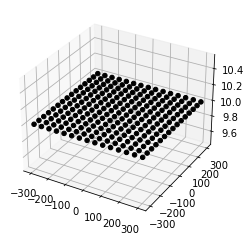

In [8]:
# tri = sp.spatial.Delaunay(topo)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection="3d")
# ax.plot_trisurf(
#     topo[:, 0], topo[:, 1], topo[:, 2], triangles=tri.simplices, cmap=plt.cm.Spectral
# )
ax.scatter3D(survey_xyz[:, 0], survey_xyz[:, 1], survey_xyz[:, 2], c="k", alpha=1)
plt.show()

In [9]:
from discretize import TensorMesh

nc = 40  # number of core mesh cells in x, y and z
dh = 20   # base cell width in x, y and z
npad = 10  # number of padding cells
exp = 1  # expansion rate of padding cells

h = [(dh, npad, -exp), (dh, nc), (dh, npad, exp)]
mesh = TensorMesh([h, h, h], x0="CCC")

# Define an active cells from topo
actv = utils.surface2ind_topo(mesh, topo)
nC = int(actv.sum())
model_map = maps.IdentityMap(nP=nC)  # model is a vlue for each active cell

mesh

/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorNx has been deprecated, please use TensorMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorNy has been deprecated, please use TensorMesh.nodes_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCy has been deprecated, please use TensorMesh.cell_centers_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warni

TensorMesh: 216,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     60       -600.00        600.00     20.00     20.00    1.00
   y     60       -600.00        600.00     20.00     20.00    1.00
   z     60       -600.00        600.00     20.00     20.00    1.00

In [10]:
ind = utils.model_builder.getIndicesSphere([0,0,-40], 120, mesh.gridCC)

magnetization = np.zeros((mesh.nC, 3))

if gauss_noise > 0:  #inflight measuremenets 

    mu, sigma = 2, 2 # mean and standard deviation
    nums = [] 

    for i in range(3*mesh.nC): 
        magnetization = random.gauss(mu, sigma)
        nums.append(magnetization) 

    magnetization = np.reshape(nums, (mesh.nC,3))

    mag_f = sp.ndimage.gaussian_filter(magnetization,2,order=0, output=None, mode='reflect', cval=0.0, truncate=4.0)
    mag_f[ind, :] = target_magnetization
    model_f = mag_f[actv, :]

magnetization[ind, :] = target_magnetization
model = magnetization[actv, :]

active_cell_map = maps.InjectActiveCells(mesh=mesh, indActive=actv, valInactive=np.nan)

In [11]:
def full_mesh_magnetization(model):
    return np.vstack([active_cell_map * model.reshape(nC, 3, order="F")[:, i] for i in range(3)]).T


def plot_vector_model(
    maxval, model, ax=None, quiver_opts=None, normal="Y", xlim=None, ylim=None, ind=None, plot_data=True, plot_grid=False
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    magnetization = full_mesh_magnetization(model)
    qo = {
        "units":"xy", "scale":np.max(np.abs(model))/20,
        "headwidth":7, "headlength":10, "headaxislength":10
    }
    
    # overwrite default vals if user provides them 
    if quiver_opts is not None:
        for key, val in quiver_opts.items(): 
            qo[key] = val 

    cb = plt.colorbar(
        mesh.plot_slice(
            magnetization, "CCv", clim=[0,maxval],normal=normal, ax=ax, view="vec", 
            grid=plot_grid, ind=ind, quiver_opts=qo
        )[0], ax=ax
    )
    
    cb.set_label("amplitude magnetization (A/m)")

    if normal.upper() == "X": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 1], survey_xyz[:, 2], "C1o", ms=2,label=False)
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
      #  ax.set_ylim([target_geometry[:,2].min()*3, survey_z.max()*4] if ylim is None else ylim)
    elif normal.upper() == "Y": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=2)
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
      #  ax.set_ylim([target_geometry[:,2].min()*3, survey_z.max()*4] if ylim is None else ylim)
    elif normal.upper() == "Z": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 1], "C1o", ms=2)
        ax.set_xlim([survey_x.min()*1.25, survey_x.max()*1.25] if xlim is None else xlim)
        ax.set_ylim([survey_x.min()*1.25, survey_x.max()*1.25] if ylim is None else ylim)
    ax.legend()
    ax.set_aspect(1)

/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


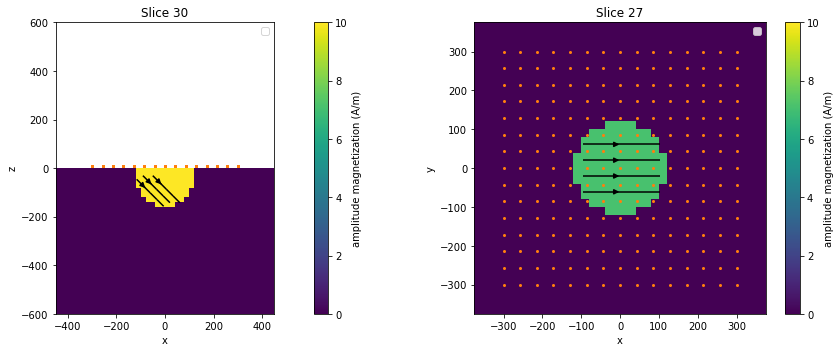

In [12]:
maxval = 5
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})
zind = 27

if gauss_noise > 0: 
    
    maxval=target_magnetization_amplitude
    plot_vector_model(maxval,model_f, ax=ax[0], normal="Y")
    plot_vector_model(maxval,model_f, ax=ax[1], normal="Z", ind=zind)  # APPEND WITHOUT GRID,plot_grid=False

    plt.tight_layout()

    fn = 'Model_Gauss.png'
    
else: 
    
    maxval=target_magnetization_amplitude
    plot_vector_model(maxval,model, ax=ax[0])
    plot_vector_model(maxval,model, ax=ax[1], normal="Z", ind=zind)  # APPEND WITHOUT GRID,plot_grid=False

    plt.tight_layout()

    fn = 'Model_Gauss.png'

In [13]:
# fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

# zind = 27
# plot_vector_model(maxval,model, ax=ax[0])
# plot_vector_model(maxval,model, ax=ax[1], normal="Z", ind=zind)  # APPEND WITHOUT GRID,plot_grid=False
# plt.tight_layout()

# fn = 'Model2.png'


In [14]:
if gauss_noise > 0: 
    model = model_f

In [15]:
def plot_target_outline(ax, normal="Y", plot_opts={"color":"C3", "lw":3}):
    if normal.upper() == "X": 
        x_target = np.hstack([target_geometry[:, 1], target_geometry[::-1, 1], target_geometry[0, 1]])
        y_target = np.hstack([target_geometry[0, 2], target_geometry[:, 2], target_geometry[::-1, 2]])
    elif normal.upper() == "Y": 
        x_target = np.hstack([target_geometry[:, 0], target_geometry[::-1, 0], target_geometry[0, 0]])
        y_target = np.hstack([target_geometry[0, 2], target_geometry[:, 2], target_geometry[::-1, 2]])
    elif normal.upper() == "Z":
        x_target = np.hstack([target_geometry[:, 0], target_geometry[::-1, 0], target_geometry[0, 0]])
        y_target = np.hstack([target_geometry[0, 1], target_geometry[:, 1], target_geometry[::-1, 1]])
    
    ax.plot(x_target, y_target, **plot_opts)

In [16]:
components = ["x", "y", "z"]
rx = mag.receivers.Point(locations=survey_xyz, components=[f"b{comp}" for comp in components])

source_field = mag.sources.SourceField(
    receiver_list=[rx], parameters=np.r_[1., 0, 0]
)
survey = mag.survey.Survey(source_field)

simulation = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=maps.IdentityMap(nP=np.prod(model.shape)), 
    actInd=actv, model_type="vector", solver=Solver
)

In [17]:
synthetic_data = simulation.make_synthetic_data(
    utils.mkvc(model), 
    noise_floor=0.1, # standard deviation of the noise in nT 
    relative_error=0,  # percent noise 
    add_noise=True  # do we add noise to the data we will use in the inversion?
) 

/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1019: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1036: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1053: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(


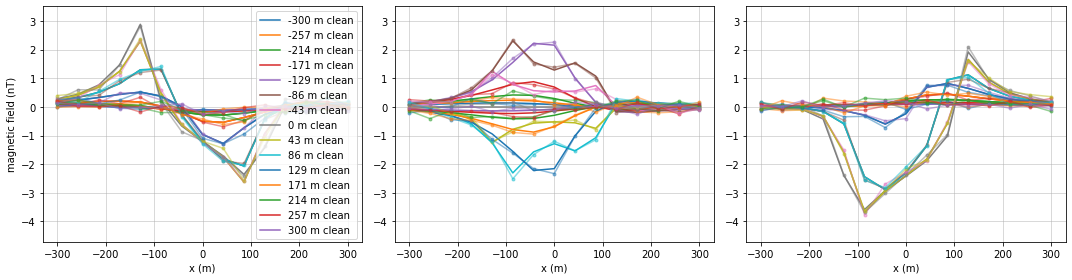

In [18]:
survey_z_s = [1]

def plot_data_profile(data, plot_opts=None, ax=None, xlim=None, ylim=None, label=True):
    data = data.reshape((survey_xyz.shape[0], len(components)))
    
    if ax is None: 
        fig, ax = plt.subplots(1, len(components), figsize=(5*len(components), 4))
        ax = np.atleast_2d(ax)
    
    po = {"ms": 3}
    if plot_opts is not None: 
        for key, val in plot_opts.items():
            po[key] = val 
    
    for k, zloc in enumerate(survey_z_s): 
        for i, component in enumerate(components):
            d = data[:, i].reshape(len(survey_x), len(survey_y), len(survey_z_s), order="F")
            for j, y in enumerate(survey_y):
                if not isinstance(label, bool):
                    l=f"{y:1.0f} m {label}"
                else:
                    l=f"{y:1.0f} m" if label is True else None
                ax[k, i].plot(survey_x, d[:, j, k], f"C{j}", label=l, **po)

            #ax[k, i].set_title(f"B{component} z={zloc}m")
            ax[k, i].grid("both", alpha=0.6)
            ax[k, i].set_ylim(1.25 * np.r_[data.min(), data.max()] if ylim is None else ylim)
            ax[k, i].set_xlim(xlim)
            ax[k, i].set_xlabel("x (m)")
    
    ax[0, 0].set_ylabel("magnetic field (nT)")
    if label is not False: 
        ax[0, 0].legend()
    plt.tight_layout()
    return ax

# In[46]:

ax = plot_data_profile(synthetic_data.dclean, label="clean")
ax = plot_data_profile(synthetic_data.dobs, ax=ax, plot_opts={"marker":"o", "alpha":0.5}, label=False)
 
fn = 'Data_Profiles.png'

In [20]:
# create the regularization
wires = maps.Wires(("x", nC), ("y", nC), ("z", nC))

reg_x = regularization.Sparse(mesh, indActive=actv, mapping=wires.x, alpha_s=1e-4, alpha_z=1e-8)
reg_y = regularization.Sparse(mesh, indActive=actv, mapping=wires.y, alpha_s=1e-4, alpha_z=1e-8)
reg_z = regularization.Sparse(mesh, indActive=actv, mapping=wires.z, alpha_s=1e-4, alpha_z=1e-8)

norms = [[2, 2, 2, 2]]
reg_x.norms = norms
reg_y.norms = norms
reg_z.norms = norms

reg = reg_x + reg_y + reg_z

# simulation2.G dimensions mismatch 
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation)

# optimization
opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=20, tolCG=1e-4
)

# inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# directives 
betaest = directives.BetaEstimate_ByEig(beta0_ratio=6)  # estimate initial trade-off parameter
sensitivity_weights = directives.UpdateSensitivityWeights()  # Add sensitivity weights
IRLS = directives.Update_IRLS()  # IRLS
update_Jacobi = directives.UpdatePreconditioner()  # Pre-conditioner
target = directives.TargetMisfit(chifact=1)  # target misfit 


inv = inversion.BaseInversion(
    inv_prob, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest, target]
)

In [21]:
nC

108000

In [23]:
m0 = np.zeros(nC * 3)
mrec_cartesian = inv.run(m0)



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.76e-04  1.79e+04  0.00e+00  1.79e+04    3.26e+02      0              
   1  3.38e-04  4.37e+02  9.25e+05  7.50e+02    2.24e+01      0              
Reached starting chifact with l2-norm regularization: Start IRLS steps...
eps_p: 4.917054665860948 eps_q: 4.917054665860948
eps_p: 4.302630453093718 eps_q: 4.302630453093718
eps_p: 5.41099112528264 eps_q: 5.41099112528264
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.7933e+03
0 : |xc-x_last| = 3.8689e+01 <= tolX*(1+|x0|) = 1.0000e-01
0 : |proj(x-g)-x|    = 2.244

/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: TensorMesh.vectorCCy has been deprecated, please use TensorMesh.cell_centers_y. It will be removed in version 1.0.0 of discretiz

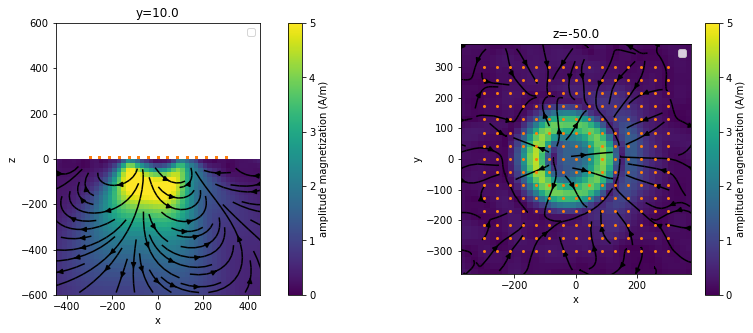

In [24]:
maxval =5
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

quiver_opts = {
    "scale":np.max(np.abs(mrec_cartesian))/20,
}

plot_vector_model(maxval,mrec_cartesian, ax=ax[0], ind=30)
plot_vector_model(maxval,mrec_cartesian, ax=ax[1], normal="Z", ind=27)
ax[0].set_title(f"y={mesh.vectorCCy[30]}")
ax[1].set_title(f"z={mesh.vectorCCz[27]}")

#plot_target_outline(ax[0], normal="Y")
#plot_target_outline(ax[1], normal="Z")

 
fn = 'L2_invmodel.png'
#plt.savefig(pn+fn)

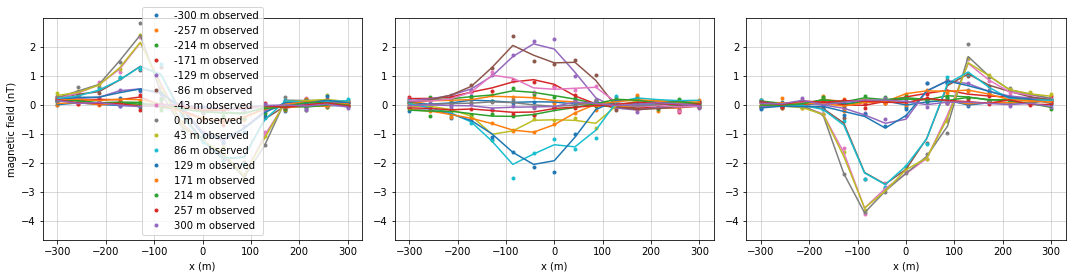

In [25]:
ax = plot_data_profile(synthetic_data.dobs, plot_opts={"marker":"o", "lw":0}, label="observed")
ax = plot_data_profile(inv_prob.dpred, ax=ax, label=False)
 
fn = 'L2_inv_obs_pred.png'

# hemispherical mapping

In [76]:
class MagnetizedSphere(maps.BaseParametric):
    """
    Mapping for a sphere of radius R in a wholespace 
    
    m = [x, y, z, r, mx, my, mz]
    
    is the position, radius and magnetization in each direction 
    """
        
    @property
    def nP(self):
        return 7

    @property
    def shape(self):
        if self.indActive is not None: 
            return (self.indActive.sum()*3, self.nP)
        return (self.mesh.nC * 3, self.nP)
    
    def _root_distance(self, m):
        x, y, z = m[0], m[1], m[2]
        return np.sqrt((self.x - x) ** 2 + (self.y - y) ** 2 + (self.z - z)**2)
    
    def _sphere(self, m):
        r = m[3]
        sphere = r - self._root_distance(m)
        return sphere

    def _sphere_deriv_x(self, m): 
        x, y, z = m[0], m[1], m[2]
        return -(self.x - x) / self._root_distance(m)
    
    def _sphere_deriv_y(self, m): 
        x, y, z = m[0], m[1], m[2]
        return -(self.y - y) / self._root_distance(m)
    
    def _sphere_deriv_z(self, m): 
        x, y, z = m[0], m[1], m[2]
        return -(self.z - z) / self._root_distance(m)
    
    def _sphere_deriv_r(self, m): 
        return -np.ones(self.indActive.sum())

    def _transform(self, m):
        mx, my, mz = m[4], m[5], m[6]
        sphere = self._atanfct(self._sphere(m), self.slope)
        return np.hstack([mx * sphere, my * sphere, mz * sphere])

    def deriv(self, m, v=None):
        mx, my, mz = m[4], m[5], m[6]
        zeros = np.zeros(self.indActive.sum())
        
        atanfctderiv = self._atanfctDeriv(self._sphere(m), self.slope)
        
        sphere_deriv_x = atanfctderiv * self._sphere_deriv_x(m)
        deriv_x = np.hstack([mx * sphere_deriv_x, my * sphere_deriv_x, mz * sphere_deriv_x]) 
        
        sphere_deriv_y = atanfctderiv * self._sphere_deriv_y(m)
        deriv_y = np.hstack([mx * sphere_deriv_y, my * sphere_deriv_y, mz * sphere_deriv_y])
        
        sphere_deriv_z = atanfctderiv * self._sphere_deriv_z(m)
        deriv_z = np.hstack([mx * sphere_deriv_z, my * sphere_deriv_z, mz * sphere_deriv_z])
        
        dr = self._atanfctDeriv(self._sphere(m), self.slope) * self._sphere_deriv_r(m)
        deriv_r = np.hstack([mx*dr, my*dr, mz*dr])
        
        sphere = self._atanfct(self._sphere(m), self.slope)
        deriv_mx = np.hstack([sphere, zeros, zeros])
        deriv_my = np.hstack([zeros, sphere, zeros])
        deriv_mz = np.hstack([zeros, zeros, sphere])
        
        deriv = sp.csr_matrix(np.c_[
            deriv_x, deriv_y, deriv_z, deriv_r, deriv_mx, deriv_my, deriv_mz
        ])
        
        if v is not None:
            return deriv * v
        return deriv

In [116]:
sphere_map = MagnetizedSphere(mesh, indActive=active_cell_map.indActive, slope=5e-1)

In [117]:
mtest = np.r_[0, 0, 0, 120, 7, 0, -7]

In [118]:
np.abs(sphere_map * mtest)[:actv.sum()].min()

0.004940993245863667

/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


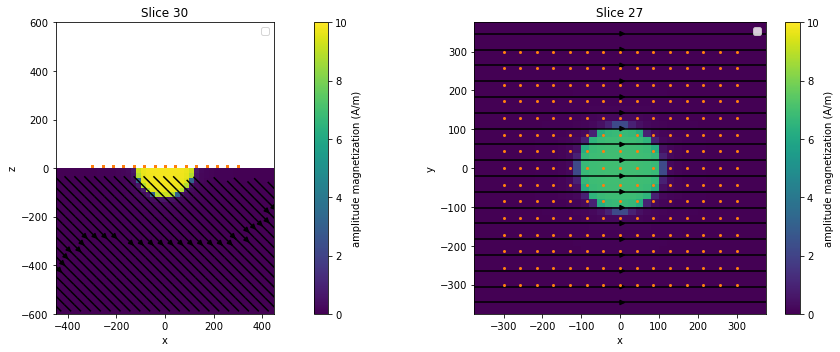

In [119]:
maxval =5
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

maxval=target_magnetization_amplitude
plot_vector_model(maxval, sphere_map * mtest, ax=ax[0])
plot_vector_model(maxval, sphere_map * mtest, ax=ax[1], normal="Z", ind=zind)  # APPEND WITHOUT GRID,plot_grid=False

plt.tight_layout()

In [120]:
sphere_map.test(mtest)

Testing MagnetizedSphere(324000,7)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------


/Users/lindseyjh/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: checkDerivative has been deprecated, please use check_derivative. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


 0   1.00e-01    1.993e+00     6.544e-02      nan
 1   1.00e-02    2.001e-01     6.466e-04      2.005
 2   1.00e-03    2.002e-02     6.457e-06      2.001
 3   1.00e-04    2.002e-03     6.456e-08      2.000
========================= PASS! =========================
Well done Lindseyjh!



True

In [121]:
simulation_parametric = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=sphere_map, 
    actInd=actv, model_type="vector", solver=Solver
)

In [122]:
# create the regularization

reg = regularization.SimpleSmall(mesh=discretize.TensorMesh([sphere_map.nP]))

# simulation2.G dimensions mismatch 
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation_parametric)

# optimization
opt = optimization.ProjectedGNCG(
    maxIter=20, maxIterLS=20, maxIterCG=20, tolCG=1e-4,
    lower=np.r_[-np.inf, -np.inf, -np.inf, 0, -np.inf, -np.inf, -np.inf]
)

# inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0)

# directives 
target = directives.TargetMisfit(chifact=1)  # target misfit 

inv = inversion.BaseInversion(
    inv_prob, directiveList=[target]
)

In [123]:
m0_parametric = np.r_[0, 0, 0, 100, 1, 1, 1]  # note: can't start at all zeros, it will fail to find a search direction
mrec_parametric = inv.run(m0_parametric)


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0


/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1019: FutureWarning: hx has been deprecated, please access as mesh.h[0]
  warnings.warn(
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1036: FutureWarning: hy has been deprecated, please access as mesh.h[1]
  warnings.warn(
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:1053: FutureWarning: hz has been deprecated, please access as mesh.h[2]
  warnings.warn(


   0  0.00e+00  1.91e+04  0.00e+00  1.91e+04    2.37e+03      0              
   1  0.00e+00  1.79e+04  6.54e+04  1.79e+04    4.02e+00      0              
   2  0.00e+00  1.79e+04  4.18e+04  1.79e+04    8.31e+00      9              
   3  0.00e+00  1.78e+04  6.63e+04  1.78e+04    7.55e+00     10              
   4  0.00e+00  1.71e+04  7.25e+04  1.71e+04    5.64e+01      8              
   5  0.00e+00  1.71e+04  7.39e+04  1.71e+04    7.80e+01      7              
   6  0.00e+00  1.71e+04  7.46e+04  1.71e+04    9.55e+01      9   Skip BFGS  
   7  0.00e+00  1.70e+04  7.41e+04  1.70e+04    1.28e+02      7   Skip BFGS  
   8  0.00e+00  1.69e+04  7.41e+04  1.69e+04    2.43e+02      5   Skip BFGS  
   9  0.00e+00  1.69e+04  7.43e+04  1.69e+04    2.63e+02     11   Skip BFGS  
  10  0.00e+00  1.69e+04  7.31e+04  1.69e+04    3.37e+02      8   Skip BFGS  
  11  0.00e+00  1.48e+04  8.75e+04  1.48e+04    1.08e+03      3   Skip BFGS  
  12  0.00e+00  1.15e+04  3.52e+04  1.15e+04    9.27e+02      2 

In [124]:
mrec_parametric

array([-3.05765303e-01,  8.30265963e-01, -3.06009023e+01,  1.18292769e+02,
        7.46155867e+00,  8.33791200e-02, -7.39417672e+00])

/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/lindseyjh/git/simpeg/discretize/discretize/base/base_tensor_mesh.py:785: FutureWarning: The zerosOutside keyword argument has been deprecated, please use zeros_outside. This will be removed in discretize 1.0.0
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


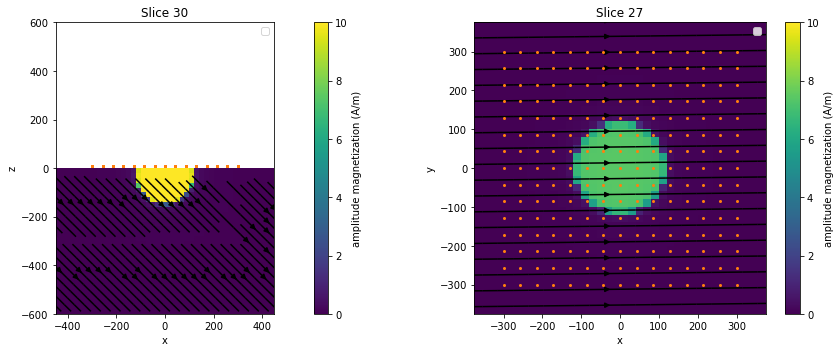

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

maxval=target_magnetization_amplitude
plot_vector_model(maxval, sphere_map * mrec_parametric, ax=ax[0])
plot_vector_model(maxval, sphere_map * mrec_parametric, ax=ax[1], normal="Z", ind=zind)  # APPEND WITHOUT GRID,plot_grid=False

plt.tight_layout()